In [12]:
from Iterative_Fast_March_Inpainting import Iterative_Fast_March_Inpainting
from matplotlib import pyplot as plt
import cv2
import numpy as np
import random
# pip install pyinpaint
# pip  install tqdm

In [13]:
def select_regions(image_path):
    # Read the image
    image = cv2.imread(image_path)
    mask = np.ones(image.shape[:2], dtype=np.uint8) * 255  # Initialize mask as white
    drawing = False
    
    def draw_freehand(event, x, y, flags, param):
        nonlocal drawing
        if event == cv2.EVENT_LBUTTONDOWN:
            drawing = True
        elif event == cv2.EVENT_MOUSEMOVE:
            if drawing:
                cv2.circle(mask, (x, y), 5, 0, -1)  # Draw black region
                cv2.circle(image, (x, y), 5, (0, 0, 0), -1)  # Visual feedback on input image
        elif event == cv2.EVENT_LBUTTONUP:
            drawing = False
    
    cv2.namedWindow("Draw Region")
    cv2.setMouseCallback("Draw Region", draw_freehand)
    
    while True:
        display = cv2.addWeighted(image, 0.7, cv2.merge([mask, mask, mask]), 0.3, 0)
        cv2.imshow("Draw Region", display)
        key = cv2.waitKey(1) & 0xFF
        if key == 13:  # Press 'Enter' to finish selection
            break
    
    cv2.destroyAllWindows()
    
    # Convert mask to 3-channel image
    bw_image = cv2.merge([mask, mask, mask])
    cv2.imwrite("bw_output.png", bw_image)
    return bw_image


In [14]:
def compute_image_metrics(original, enhanced):
    """
    Computes PSNR, MSE, and SSIM between the original and enhanced images, 
    and prints the method names with corresponding values.
    
    Args:
    original (ndarray): The original image (BGR format).
    enhanced (ndarray): The enhanced image (BGR format).
    """
    original = plt.imread(original)

    # Calculate PSNR (Peak Signal-to-Noise Ratio)
    mse_val = np.mean((original - enhanced) ** 2)
    if mse_val == 0:
        psnr_value = 100  # Perfect match (no error)
    else:
        max_pixel = 255.0  # Max pixel value for an 8-bit image
        psnr_value = 20 * log10(max_pixel / sqrt(mse_val))
    
    # Calculate MSE (Mean Squared Error)
    mse_value = np.mean((original - enhanced) ** 2)

    # Calculate SSIM (Structural Similarity Index)
    ssim_value = ssim(original, enhanced, multichannel=True)
    return psnr_value, mse_value, ssim_value

In [15]:
def nearest_neighbor_pixel_replacement(org_img, mask):
    org_img = cv2.imread(org_img)
    mask = cv2.imread(mask, cv2.IMREAD_GRAYSCALE)  # Load mask in grayscale
    mask = np.uint8(mask)

    # Ensure mask is binary (0 = region to inpaint, 255 = region to keep)
    _, mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

    # Create a copy of the original image
    inpainted_img = org_img.copy()

    # Iterate over all pixels in the image
    for y in range(org_img.shape[0]):
        for x in range(org_img.shape[1]):
            if mask[y, x] == 0:  # If the pixel is masked (to be inpainted)
                # Pick a random valid neighbor instead of the nearest
                nearest_pixel = find_random_valid_pixel(org_img, mask, x, y)
                inpainted_img[y, x] = nearest_pixel

    return inpainted_img

def find_random_valid_pixel(img, mask, x, y):
    search_radius = 5
    candidates = []

    for dx in range(-search_radius, search_radius + 1):
        for dy in range(-search_radius, search_radius + 1):
            nx, ny = x + dx, y + dy
            if 0 <= nx < img.shape[1] and 0 <= ny < img.shape[0]:
                if mask[ny, nx] == 255:  # If the pixel is not masked
                    candidates.append(img[ny, nx])

    if candidates:
        random.shuffle(candidates)  # Shuffle the pixel candidates
        return candidates[0]  # Pick the first after shuffle
    return img[y, x]  # Fallback

In [16]:
def show_images(org_img, mask, inpainted_img):
    org_img = plt.imread(org_img)
    org_img = (org_img - org_img.min()) /(org_img.max() - org_img.min())
    mask = plt.imread(mask)
    f = plt.figure(figsize=(20,20))
    f.add_subplot(1,3,1)
    plt.imshow(org_img, cmap="gray")
    plt.axis("off")
    plt.title("ORIGINAL")
    f.add_subplot(1,3,2)
    plt.imshow((org_img.T * mask.T).T, cmap="gray")
    plt.axis("off")
    plt.title("MASKED")
    f.add_subplot(1,3,3)
    plt.imshow(inpainted_img, cmap="gray")
    plt.axis("off")
    plt.title("INPAINTED")
    #plt.savefig("out.jpg",bbox_inches="tight")
    plt.show

In [17]:
org_img = "data/dog.png"
#select_regions(org_img)
#mask = r"bw_output.png"

In [18]:
from math import log10,sqrt
from skimage.metrics import structural_similarity as ssim


z:\python\lib\site-packages\ipykernel_launcher.py:24: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.





Existing Method: PSNR, Value: 10.35 dB
Existing Method: MSE, Value: 5999.18
Existing Method: SSIM, Value: 0.0002


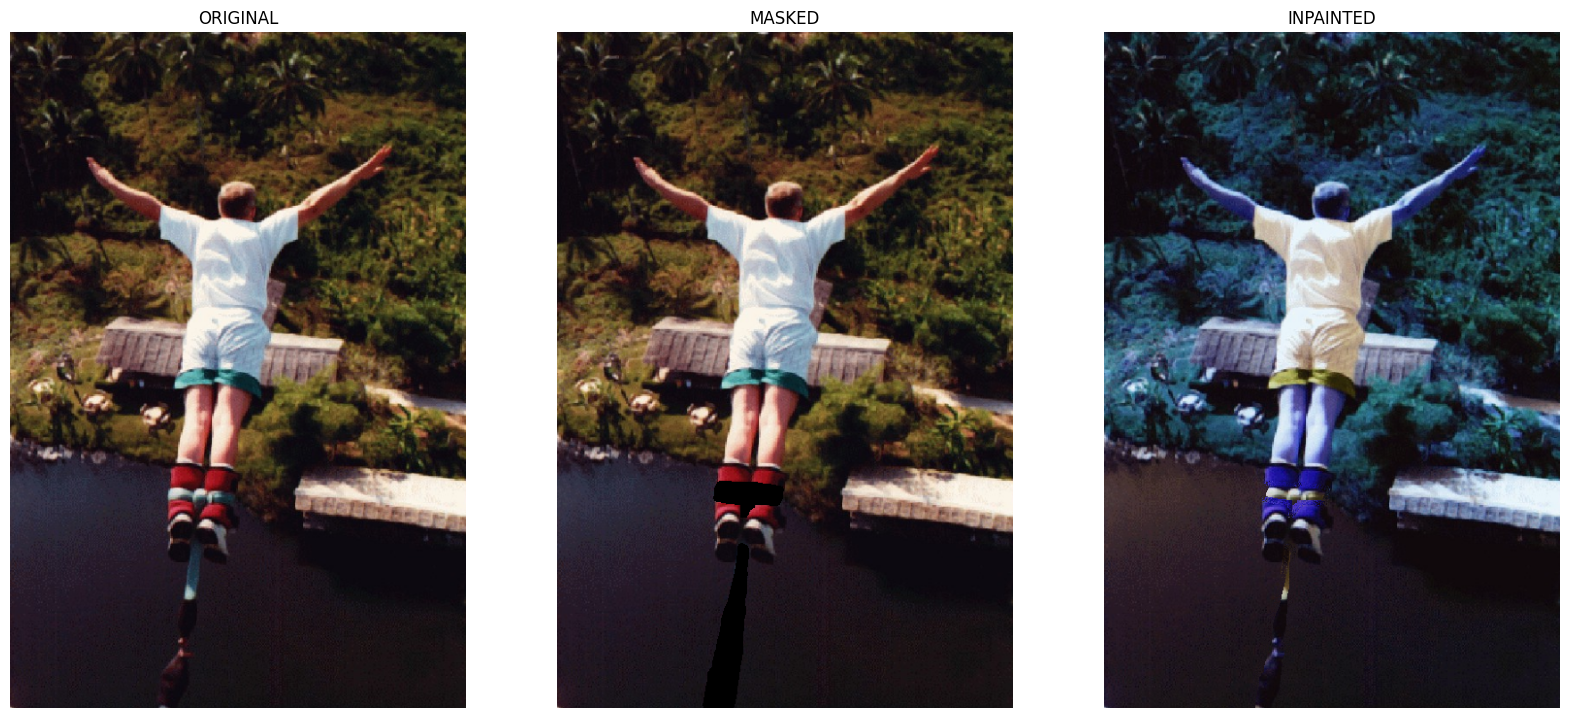

In [19]:
org_img = "data/fly.png"
mask = r"data/fly_mask.png"
inpainted_img=nearest_neighbor_pixel_replacement(org_img, mask)
show_images(org_img, mask, inpainted_img)

psnr_value,mse_value,ssim_value = compute_image_metrics(org_img, inpainted_img)

# Print Method Names and Corresponding Values
print(f"\n\n")
input_text="Existing Method"
print(f"{input_text}: PSNR, Value: {psnr_value:.2f} dB")
print(f"{input_text}: MSE, Value: {mse_value:.2f}")
print(f"{input_text}: SSIM, Value: {ssim_value:.4f}")
        

z:\python\lib\site-packages\ipykernel_launcher.py:24: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.





Existing Method: PSNR, Value: 29.75 dB
Existing Method: MSE, Value: 68.94
Existing Method: SSIM, Value: 0.8894


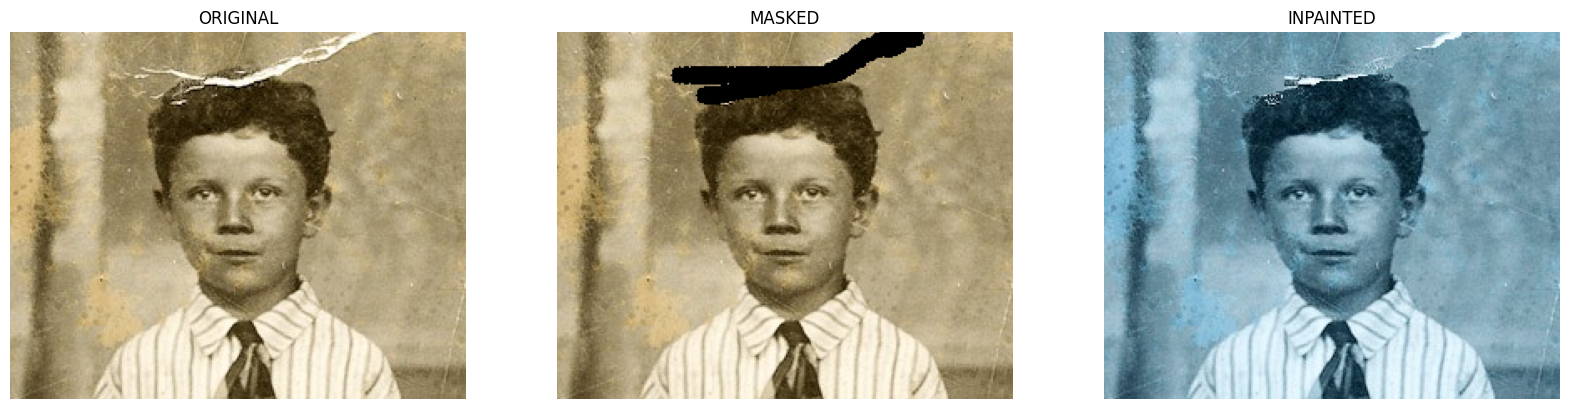

In [20]:
org_img = "data/Kid.jpg"
mask = r"data/Kid_Mask_output.png"
inpainted_img=nearest_neighbor_pixel_replacement(org_img, mask)
show_images(org_img, mask, inpainted_img)

psnr_value,mse_value,ssim_value = compute_image_metrics(org_img, inpainted_img)

# Print Method Names and Corresponding Values
print(f"\n\n")
input_text="Existing Method"
print(f"{input_text}: PSNR, Value: {psnr_value:.2f} dB")
print(f"{input_text}: MSE, Value: {mse_value:.2f}")
print(f"{input_text}: SSIM, Value: {ssim_value:.4f}")

In [ ]:
org_img = "data/fly.png"
mask = r"data/fly_mask.png"

inpaint = Iterative_Fast_March_Inpainting(org_img, mask,7)
inpainted_img = inpaint()
show_images(org_img, mask, inpainted_img)

psnr_value,mse_value,ssim_value = compute_image_metrics(org_img, inpainted_img)

# Print Method Names and Corresponding Values
print(f"\n\n")
input_text="Proposed Method"
print(f"{input_text}: PSNR, Value: {psnr_value:.2f} dB")
print(f"{input_text}: MSE, Value: {mse_value:.2f}")
print(f"{input_text}: SSIM, Value: {ssim_value:.4f}")
        

# of pixels to be inpainted are 5721:  39%|█████████████████████████▊                                        |2237/5721

In [ ]:
org_img = "data/Kid.jpg"
mask = r"data/Kid_Mask_output.png"
inpaint = Iterative_Fast_March_Inpainting(org_img, mask, ps=9)

inpainted_img = inpaint(k_boundary=8, k_search=1000, k_patch=7)

show_images(org_img, mask, inpainted_img)

psnr_value,mse_value,ssim_value = compute_image_metrics(org_img, inpainted_img)

# Print Method Names and Corresponding Values
print(f"\n\n")
input_text="Proposed Method"
print(f"{input_text}: PSNR, Value: {psnr_value:.2f} dB")
print(f"{input_text}: MSE, Value: {mse_value:.2f}")
print(f"{input_text}: SSIM, Value: {ssim_value:.4f}")